In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import joblib
import torch
from Models.models import NNdynamic, plot_confusion_matrix, plot_metrics

In [2]:
data = pd.read_csv('Cleaned_full_data.csv')

C:\Users\adi_s\AppData\Local\Temp\ipykernel_7776\2584280520.py:1: DtypeWarning: Columns (1,3) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('Cleaned_full_data.csv')


In [3]:
# Reset retained index.
data = data.reset_index(drop=True)
# Set NA to 0.
data['ct_ftp_cmd'] = data['ct_ftp_cmd'].fillna(0)
data['attack_cat'] = data['attack_cat'].str.replace(r'\s+', '', regex=True)
data['attack_cat'] = data['attack_cat'].str.replace('Backdoors', 'Backdoor')

In [4]:
data = data.drop(columns=['proto', 'dsport', 'service', 'state', 'srcip', 'sport', 'dstip'])

In [5]:
temp = data[['is_ftp_login', 'is_sm_ips_ports', 'label', 'attack_cat']]
data = data.drop(columns=['is_ftp_login', 'is_sm_ips_ports', 'label', 'attack_cat'])

In [6]:
# The resulting encoded features can be found in Tools/EncoderTests.
ohe1 = pd.read_csv('Full_proto_encoded.csv')
ohe2 = pd.read_csv('Full_dsport_encoded.csv')
ohe3 = pd.read_csv('Full_service_encoded.csv')
ohe4 = pd.read_csv('Full_state_encoded.csv')
# Spelling error.
ohe5 = pd.read_csv('Full_scrip_encoded.csv')
#------------------------------------------#
ohe6 = pd.read_csv('Full_sport_encoded.csv')
ohe7 = pd.read_csv('Full_dstip_encoded.csv')

In [7]:
# MinMax seperates Normal data well and reduces noise. Please see Kmeans TSNE evaluation in Tools.
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)
data = pd.DataFrame(scaled_data, columns=data.columns)
data = pd.concat([data, temp, ohe1, ohe2, ohe3, ohe4, ohe5, ohe6, ohe7], axis=1)

In [8]:
X_temp = data.drop(columns=['label'])
y = data['label']
X_train, X_test, y_train, y_test = train_test_split(
    X_temp, y, test_size=0.2, random_state=42)
test_attack_cat = X_test['attack_cat']
print('Train:', y_train.value_counts())
print('Test', y_test.value_counts())
X_train = X_train.drop(columns=['attack_cat'])
X_test = X_test.drop(columns=['attack_cat'])

Train: label
0    1774933
1     257104
Name: count, dtype: int64
Test label
0    443831
1     64179
Name: count, dtype: int64


In [9]:
# Prepare batches.
batch_size = 128
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_features = X_train_tensor.shape[1]
fc_size = 128
save_dir = './Models/saved_models/128/smote/'
model1 = NNdynamic(n_features, fc_size, device, save_dir)

Epoch 1/5: 100%|██████████| 15876/15876 [04:08<00:00, 63.93batch/s]


Epoch [1/5], Train Loss: 0.0209, Train Acc: 0.9914, Train F1: 0.9914


Epoch 2/5: 100%|██████████| 15876/15876 [04:02<00:00, 65.48batch/s]


Epoch [2/5], Train Loss: 0.0195, Train Acc: 0.9920, Train F1: 0.9920


Epoch 3/5: 100%|██████████| 15876/15876 [04:06<00:00, 64.40batch/s]


Epoch [3/5], Train Loss: 0.0205, Train Acc: 0.9925, Train F1: 0.9925


Epoch 4/5: 100%|██████████| 15876/15876 [04:14<00:00, 62.36batch/s]


Epoch [4/5], Train Loss: 0.0216, Train Acc: 0.9927, Train F1: 0.9927


Epoch 5/5: 100%|██████████| 15876/15876 [04:12<00:00, 62.78batch/s]


Epoch [5/5], Train Loss: 0.0212, Train Acc: 0.9926, Train F1: 0.9926


Testing: 100%|██████████| 3969/3969 [00:11<00:00, 335.86batch/s]


Test Loss: 0.0182, Test Accuracy: 0.9878, Test F1: 0.9882


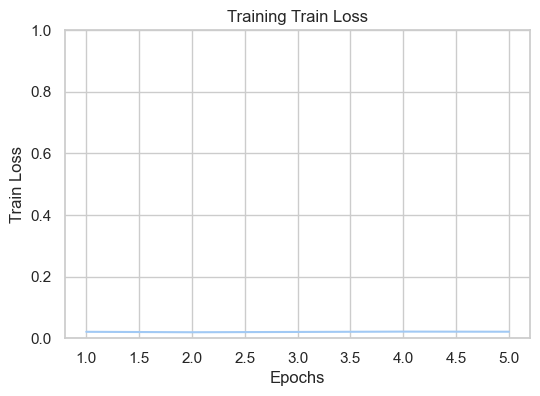

SMOTE Test


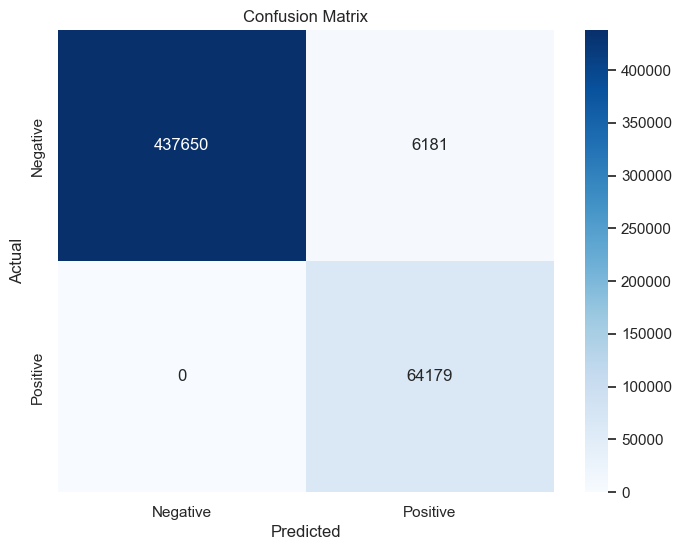

In [11]:
sampler = 'smote'
params = {'k_neighbors': 2}
learning_rate = 0.1
epochs = 5
save_factor = 1
model1.run(train_loader, learning_rate, epochs, save_factor, sampler, params)
model1.test(test_loader)
plot_metrics(model1.train_loss, len(model1.train_loss), title="Train Loss")
print('SMOTE Test')
labels = test_dataset.tensors[1]
plot_confusion_matrix(labels, model1.test_predicted)

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_features = X_train_tensor.shape[1]
fc_size = 128
save_dir = './Models/saved_models/128/smote/'
model1 = NNdynamic(n_features, fc_size, device, save_dir)

In [15]:
model1.load_model('./Models/saved_models/smote/PB_epoch_5.pth')

NameError: name 'model' is not defined

In [ ]:

model1.test(test_loader)
plot_metrics(model1.train_loss, len(model1.train_loss), title="Train Loss")
print('SMOTE Test')
labels = test_dataset.tensors[1]
plot_confusion_matrix(labels, model1.test_predicted)

NameError: name 'model' is not defined

In [ ]:
modelx = NNdynamic(train_loader, 128, device, None)
modelx.load_model('./Models/saved_models/smote/PB_epoch_1.pth')

In [13]:
import shap

In [14]:
xp = shap.GradientExplainer(model1, X_test_tensor[:1000])
sh = xp.shap_values(X_test_tensor[:1000])

TypeError: empty(): argument 'size' failed to unpack the object at pos 2 with error "type must be tuple of ints,but got DataLoader"

In [12]:
for i in range(1, epochs+1):
    path = f"./Models/saved_models/smote/PB_epoch_{i}.pth"
    model = model1.load_model(path)
    print(f"Epoch: {i}")
    model.test(test_loader)
    y_pred = np.array(model.test_predicted)
    y_true = []
    for _, labels in test_loader:
        y_true.extend(labels.numpy())
    y_true = np.array(y_true)
    plot_confusion_matrix(y_true, y_pred)
    model.test_predicted = []

AttributeError: 'NNdynamic' object has no attribute 'args'

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_features = X_train_tensor.shape[1]
fc_size = 128
save_dir = './Models/saved_models/tomeks/'
model2 = NNdynamic(n_features, fc_size, device, save_dir)

In [ ]:
sampler = 'tomeks'
params = {'sampling_strategy': 'auto'}
learning_rate = 0.1
epochs = 5
save_factor = 1
model2.run(train_loader, learning_rate, epochs, save_factor, sampler, params)
model2.test(test_loader)
plot_metrics(model1.train_loss, len(model2.train_loss), title="Train Loss")
print('Tomeks Test')
labels = test_dataset.tensors[1]
plot_confusion_matrix(labels, model2.test_predicted)


In [ ]:
for i in range(1, epochs+1):
    path = f"./Models/saved_models/tomeks/PB_epoch_{i}.pth"
    model = model1.load_model(path)
    print(f"Epoch: {i}")
    model.test(test_loader)
    y_pred = np.array(model.test_predicted)
    y_true = []
    for _, labels in test_loader:
        y_true.extend(labels.numpy())
    y_true = np.array(y_true)
    plot_confusion_matrix(y_true, y_pred)
    model.test_predicted = []

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_features = X_train_tensor.shape[1]
fc_size = 128
save_dir = './Models/saved_models/edited_nearest/'
model2 = NNdynamic(n_features, fc_size, device, save_dir)

In [ ]:
sampler = 'edited_nearest'
params = {'n_neighbors': 2}
learning_rate = 0.1
epochs = 5
save_factor = 1
model2.run(train_loader, learning_rate, epochs, save_factor, sampler, params)
model2.test(test_loader)
plot_metrics(model1.train_loss, len(model2.train_loss), title="Train Loss")
model2.test(test_loader)
print('Edited Nearest Test')
labels = test_dataset.tensors[1]
plot_confusion_matrix(labels, model2.test_predicted)

In [ ]:
for i in range(1, epochs+1):
    path = f"./Models/saved_models/edited_nearest/PB_epoch_{i}.pth"
    model = model1.load_model(path)
    print(f"Epoch: {i}")
    model.test(test_loader)
    y_pred = np.array(model.test_predicted)
    y_true = []
    for _, labels in test_loader:
        y_true.extend(labels.numpy())
    y_true = np.array(y_true)
    plot_confusion_matrix(y_true, y_pred)
    model.test_predicted = []

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_features = X_train_tensor.shape[1]
fc_size = 128
save_dir = './Models/saved_models/near_miss/'
model2 = NNdynamic(n_features, fc_size, device, save_dir)

In [ ]:
sampler = 'near_miss'
params = {'n_neighbors': 2}
learning_rate = 0.1
epochs = 5
save_factor = 1
model2.run(train_loader, learning_rate, epochs, save_factor, sampler, params)
model2.test(test_loader)
plot_metrics(model1.train_loss, len(model2.train_loss), title="Train Loss")
model2.test(test_loader)
print('Near Miss Test')
labels = test_dataset.tensors[1]
plot_confusion_matrix(labels, model2.test_predicted)

In [ ]:
for i in range(1, epochs+1):
    path = f"./Models/saved_models/near_miss/PB_epoch_{i}.pth"
    model = model1.load_model(path)
    print(f"Epoch: {i}")
    model.test(test_loader)
    y_pred = np.array(model.test_predicted)
    y_true = []
    for _, labels in test_loader:
        y_true.extend(labels.numpy())
    y_true = np.array(y_true)
    plot_confusion_matrix(y_true, y_pred)
    model.test_predicted = []

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_features = X_train_tensor.shape[1]
fc_size = 128
save_dir = './Models/saved_models/condensed_nearest/'
model2 = NNdynamic(n_features, fc_size, device, save_dir)

In [ ]:
sampler = 'condensed_nearest'
params = {'n_neighbors': 2}
learning_rate = 0.1
epochs = 5
save_factor = 1
model2.run(train_loader, learning_rate, epochs, save_factor, sampler, params)
model2.test(test_loader)
plot_metrics(model1.train_loss, len(model2.train_loss), title="Train Loss")
model2.test(test_loader)
print('Condensed Nearest Test')
labels = test_dataset.tensors[1]
plot_confusion_matrix(labels, model2.test_predicted)

In [ ]:
for i in range(1, epochs+1):
    path = f"./Models/saved_models/condensed_nearest/PB_epoch_{i}.pth"
    model = model1.load_model(path)
    print(f"Epoch: {i}")
    model.test(test_loader)
    y_pred = np.array(model.test_predicted)
    y_true = []
    for _, labels in test_loader:
        y_true.extend(labels.numpy())
    y_true = np.array(y_true)
    plot_confusion_matrix(y_true, y_pred)
    model.test_predicted = []

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_features = X_train_tensor.shape[1]
fc_size = 128
save_dir = './Models/saved_models/one_sided_1/'
model2 = NNdynamic(n_features, fc_size, device, save_dir)

In [ ]:
sampler = 'one_sided'
params = {'n_neighbors': None}
learning_rate = 0.1
epochs = 5
save_factor = 1
model2.run(train_loader, learning_rate, epochs, save_factor, sampler, params)
model2.test(test_loader)
plot_metrics(model1.train_loss, len(model2.train_loss), title="Train Loss")
model2.test(test_loader)
print('One Sided Selection Test')
labels = test_dataset.tensors[1]
plot_confusion_matrix(labels, model2.test_predicted)

In [ ]:
for i in range(1, epochs+1):
    path = f"./Models/saved_models/one_sided_1/PB_epoch_{i}.pth"
    model = model1.load_model(path)
    print(f"Epoch: {i}")
    model.test(test_loader)
    y_pred = np.array(model.test_predicted)
    y_true = []
    for _, labels in test_loader:
        y_true.extend(labels.numpy())
    y_true = np.array(y_true)
    plot_confusion_matrix(y_true, y_pred)
    model.test_predicted = []

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_features = X_train_tensor.shape[1]
fc_size = 128
save_dir = './Models/saved_models/one_sided_2/'
model2 = NNdynamic(n_features, fc_size, device, save_dir)

In [ ]:
sampler = 'one_sided'
params = {'n_neighbors': None}
learning_rate = 0.1
epochs = 5
save_factor = 1
model2.run(train_loader, learning_rate, epochs, save_factor, sampler, params)
model2.test(test_loader)
plot_metrics(model1.train_loss, len(model2.train_loss), title="Train Loss")
model2.test(test_loader)
print('One Sided Selection Test')
labels = test_dataset.tensors[1]
plot_confusion_matrix(labels, model2.test_predicted)

In [ ]:
for i in range(1, epochs+1):
    path = f"./Models/saved_models/one_sided_2/PB_epoch_{i}.pth"
    model = model1.load_model(path)
    print(f"Epoch: {i}")
    model.test(test_loader)
    y_pred = np.array(model.test_predicted)
    y_true = []
    for _, labels in test_loader:
        y_true.extend(labels.numpy())
    y_true = np.array(y_true)
    plot_confusion_matrix(y_true, y_pred)
    model.test_predicted = []

# Increase Batch Size and Dense Layers.